In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import sqlite3
from datetime import date
from datetime import datetime as dt
import hashlib
import sys
import os
import locale
import re
import requests as rq
import wbdata as wb
from contextlib import contextmanager
import pytz
from datetime import timedelta
from currency_converter import CurrencyConverter
cc=CurrencyConverter()
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
import numpy as np
from technical_analysis import candles
from technical_analysis import overlays
from technical_analysis import indicators


project_dir = '/home/mi/Dropbox/prog/python/tradeDB'
os.chdir(project_dir)

from importlib import reload
#from workers import sql
from workers import api
#from workers.common import read_json, hash_table
import tradeDB

In [2]:
stock= tradeDB.Trader()

In [3]:
stock.get(tab='STOCK',components='wig20')
ind = stock.to_str('symbol')
stock.get(tab='STOCK',symbol=ind, start_date='1-01-2010', currency='USD')


In [4]:
wig20=tradeDB.Trader()
wig20.get(tab='INDEXES',symbol='wig20')
spx=tradeDB.Trader()
spx.get(tab='INDEXES',symbol='^spx')

Date range set to last working day.
Select start_date and/or end_date if you want different dates.
Date range set to last working day.
Select start_date and/or end_date if you want different dates.


In [5]:
stock = stock+spx+wig20

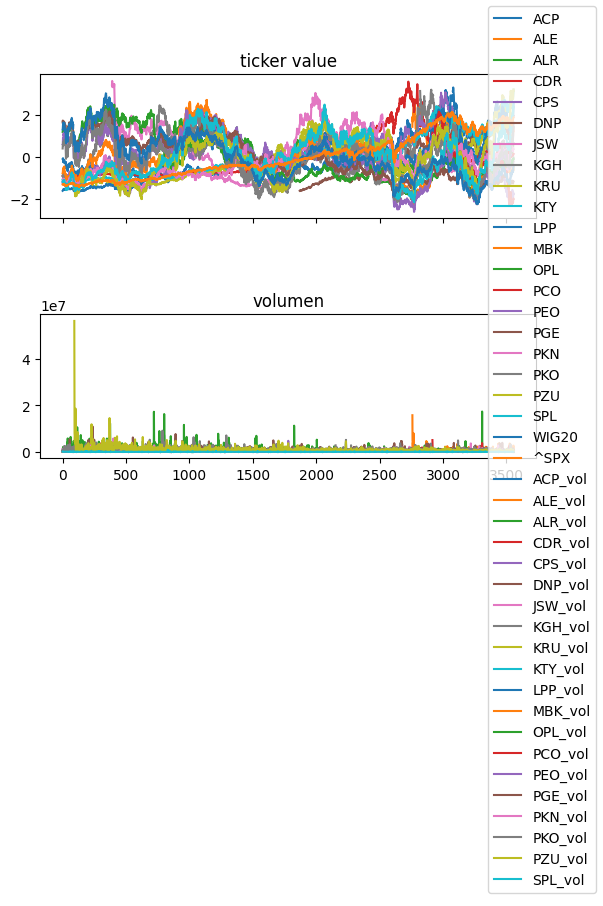

In [6]:
stock.plot()

In [9]:
pkn=tradeDB.Trader()
ale=tradeDB.Trader()
pkn.get(tab='stock',symbol='pkn',columns='-indexes;-industry;-info', start_date='1-1-2020')
ale.get(tab='stock',symbol='ale')
pkn+=ale

Date range set to last working day.
Select start_date and/or end_date if you want different dates.


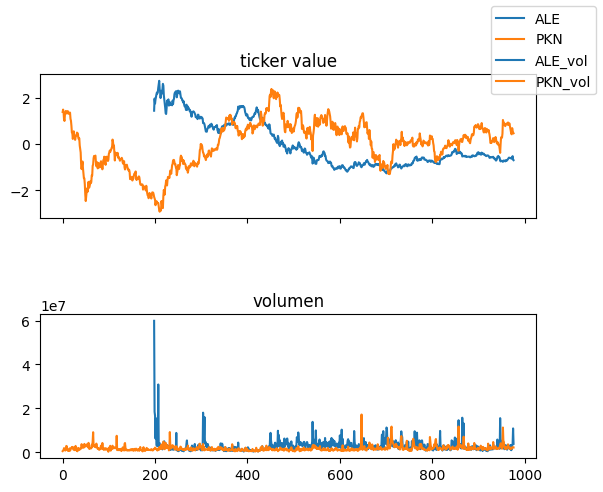

In [10]:
pkn.plot()

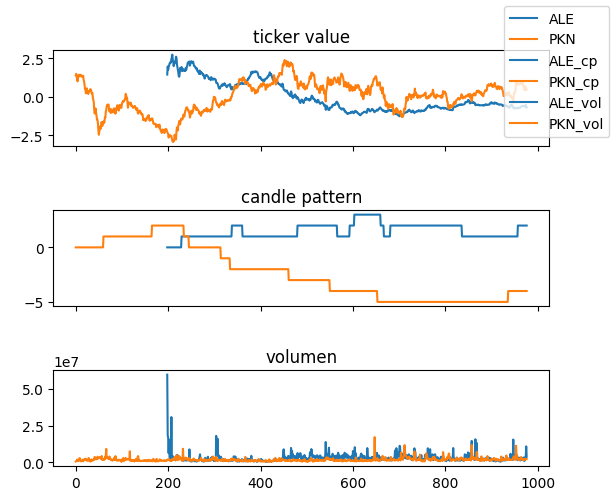

In [11]:
pkn.candle_pattern()
pkn.plot()

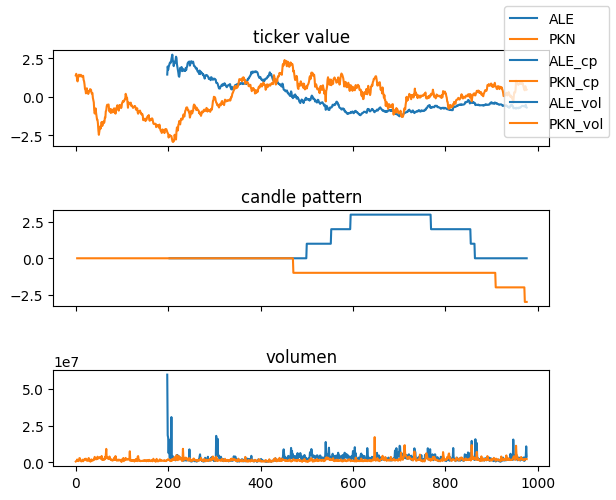

In [12]:
pkn.candle_pattern('W')
pkn.plot()

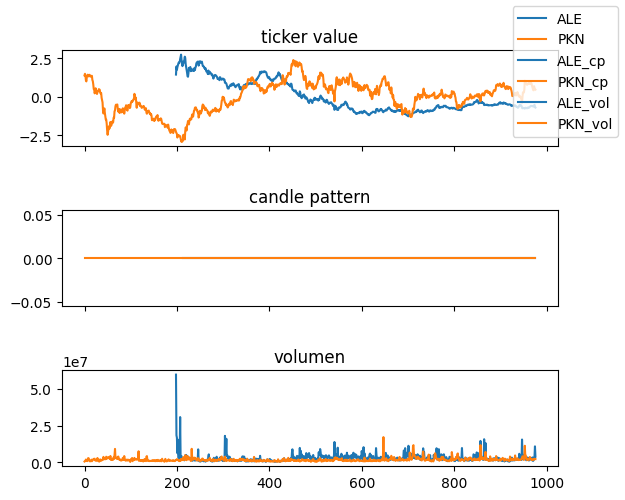

In [13]:
pkn.candle_pattern('M')
pkn.plot()